# Data preprocessing

This notebook selects data from the relevant facility and combines the different csv files into a single one to serve as the starting point of the feature creation.

The main meter values are corrected for rollover, and the external environment temperatures are combined as an inverse distance weighted average.

While the full raw data files data contain information on 3 separate facilities, analysis is done on the site with seven years of historic data only.

Some preprocessing steps are unique to this site as the other sites do not have cumulative meters.

In [2]:
import copy
import gc
import calendar

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder  

Raw data file paths

In [3]:
powerdata_file = 'Power_Laws_Detecting_Anomalies_in_Usage_-_Training_Data.csv'
meta_data_file = 'Power_Laws_Detecting_Anomalies_in_Usage_-_Metadata.csv'
holiday_data_file = 'Power_Laws_Detecting_Anomalies_in_Usage_-_Holidays.csv'
weather_data_file = 'Power_Laws_Detecting_Anomalies_in_Usage_-_Weather.csv'

Load raw data

In [4]:
def load_power_data(file_path):
    """Load csv data file to pd array with types specified"""
    return pd.read_csv(file_path, low_memory=False, dtype={'meter_id':str, 'site_id':str })

train = load_power_data(powerdata_file)
mdat = load_power_data(meta_data_file)
holids = load_power_data(holiday_data_file)
wdat = load_power_data(weather_data_file)

Preliminary cleaning

In [5]:
def format_time(time_col, just_date=False):
    """Predefined time formatting for this data"""
    if just_date:
        return  pd.to_datetime(time_col, format='%Y-%m-%d')
    else:
        return pd.to_datetime(time_col, format='%Y-%m-%d %H:%M:%S')


In [6]:
# improve column naming
holids.rename(columns = {'Date':'date'},inplace=True)

#drop unneeded column
train.drop('Unnamed: 0',axis=1,inplace=True)

#correct site id nomenclature for weather data
wdat_bad_site_id_mask = (wdat['site_id'] == '38')
wdat.loc[wdat_bad_site_id_mask, 'site_id'] = '038'

# format time columns
train['Timestamp'] = format_time(train['Timestamp'])
holids['date'] = format_time(holids['date'], just_date=True)

train.index = train['Timestamp']
wdat.dropna(inplace=True)



## Facility selection 

Get the main meter and meters from the targetted facility

In [7]:
# get the meters at the facility site of interest
SITE_NO = 2

# site ids
sites = mdat.site_id.unique()

#all meters at selected site
meters = set(mdat[mdat.site_id==sites[SITE_NO]].meter_id)

#main meters all sites
main_meters = ['234_203', '334_61', '38_9686']

#main meter current site
curr_main_meter =  list(meters.intersection( set(main_meters)))[0]
print('target',curr_main_meter)

target 38_9686


In [8]:
# Discard data from the other facilities.

In [9]:
def get_site(df, meters, site):
    """Return data only for specified meters or site"""
    if 'meter_id' in df:
        return df[df.meter_id.isin(meters)]
    elif 'site_id' in df:
        return df[df.site_id == site]
    


In [10]:
#return data only for the site of interest

train = get_site(train, meters, sites[SITE_NO])
mdat = get_site(mdat, meters, sites[SITE_NO])
wdat = get_site(wdat, meters, sites[SITE_NO])
holids = get_site(holids, meters, sites[SITE_NO])


# Feature data frame

Create initial feature data frame

In [11]:
#get data for the main meter as the starting feature data frame
targ_meters_mask = train.meter_id==curr_main_meter
target = train[targ_meters_mask].copy()
del targ_meters_mask

target.drop(['meter_id'],inplace=True, axis=1)


In [12]:
old_nulls = target[(target.Values.isnull())]

In [13]:
target.dropna(subset = ['Values'], inplace=True)
print(target.sample(2))

                              Timestamp     Values
Timestamp                                         
2011-05-01 19:30:00 2011-05-01 19:30:00  5023451.5
2014-07-20 09:45:00 2014-07-20 09:45:00  3216969.0


In [14]:
target[target['Values']<=0].Values

Series([], Name: Values, dtype: float64)

In [15]:
target[(target.Values.isnull())]

,Timestamp,Values
Timestamp,,


Some reading are show a zero electricity consumption for several hours, this is clearly odd.
but how should it be treated? Seems like it is often during holiday, could be a time maintenance on the power grid. Perhaps equipment is shifted to an auxillary generator?

Currently no treatment is taken. It is assumed these were planned maintenance shutdowns with power coming from an auxillary source during that time.

In [16]:
# zero usage time example
# target['2011-12-27 09:45:00':'2011-12-27 15:45:00']


## correct meter roll overs

In [17]:
# correct data for meter rollovers

target['temp_diff'] = target['Values'].diff()

rollover_correction = 0 
new_vals = []
prior_val = 0

for i, row in enumerate(target.itertuples()):
    if row.temp_diff < (- (1*10**6)):
        rollover_correction += 10**7
        print(row.Timestamp,prior_val, row.Values, row.temp_diff,rollover_correction )
        
    prior_val = row.Values
    new_vals.append(row.Values + rollover_correction)
    
target['Values'] = new_vals
target.drop('temp_diff', axis=1, inplace=True)

target['Values_d'] = target['Values'].diff()

2012-02-24 07:30:00 9999773.0 113.716484069824 -9999659.28351593 10000000
2013-12-05 07:00:00 9999839.0 129.577835083008 -9999709.422164917 20000000
2015-11-05 07:15:00 9999853.0 88.6992034912109 -9999764.300796509 30000000
2017-09-20 00:15:00 9999934.0 12.3088903427124 -9999921.691109657 40000000


## Correct for meter pauses

In [18]:
#check for odd constant values
# target[target['Values_d']<=0].Values

Interpolate missing data while meter readings are still in a cumulative format

In [19]:
print(target['Timestamp'].diff().value_counts())


00:15:00    254551
01:15:00         7
01:30:00         3
01:00:00         3
00:30:00         3
00:45:00         2
02:15:00         1
Name: Timestamp, dtype: int64


In [20]:
#values were the missed a couple readings include all the usage in the next reading, seemedly.
target['2017-02-04 17:15:00':'2017-02-04 20:45:00']

,Timestamp,Values,Values_d
Timestamp,,,
2017-02-04 17:15:00,2017-02-04 17:15:00,36776029.5,99.0
2017-02-04 17:30:00,2017-02-04 17:30:00,36776135.0,105.5
2017-02-04 17:45:00,2017-02-04 17:45:00,36776242.5,107.5
2017-02-04 18:00:00,2017-02-04 18:00:00,36776347.0,104.5
2017-02-04 20:15:00,2017-02-04 20:15:00,36777226.5,879.5
2017-02-04 20:30:00,2017-02-04 20:30:00,36777320.5,94.0
2017-02-04 20:45:00,2017-02-04 20:45:00,36777416.5,96.0


In [21]:
#fix stuck meters
target['tdelt']=target.Timestamp.diff()
target = target.resample('15T').interpolate(method='time')
target['Timestamp']=target.index

Change target values to be the fifteen minute usage, not the cumulative usage

In [22]:
#Change target values to be the fifteen minute usage, not the cumulative usage
target['Values'] = target['Values'].diff()
target.drop('Values_d', axis=1, inplace=True)

# preview data

Text(0,0.5,'kWh electric')

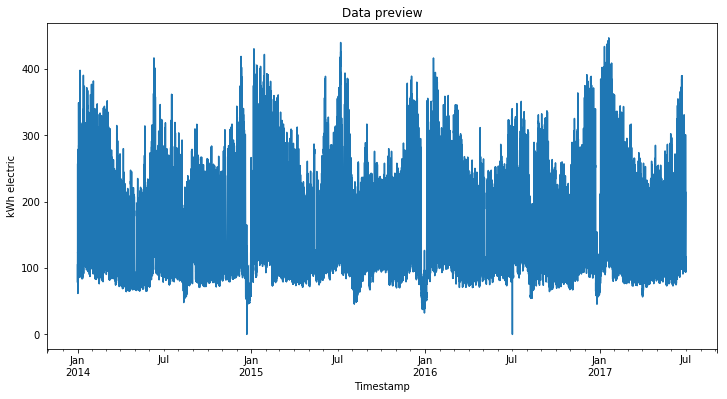

In [23]:
target['1-1-2014':'7-1-2017']['Values'].plot(figsize=(12,6))
plt.title('Data preview')
plt.ylabel('kWh electric')

# Add day of week features

In [24]:
target['DofW'] = target.Timestamp.dt.dayofweek
target['year'] = target.Timestamp.dt.year
target['month'] = target.Timestamp.dt.month
target['hour'] = target.Timestamp.dt.hour + target.Timestamp.dt.minute/60
target['week'] = target.Timestamp.dt.week
target['day'] = target.Timestamp.dt.day
target['DofY'] = target.Timestamp.dt.dayofyear
target['date'] = target.Timestamp.dt.date

In [25]:
target.head()

,Timestamp,Values,tdelt,DofW,year,month,hour,week,day,DofY,date
Timestamp,,,,,,,,,,,
2010-08-31 22:00:00,2010-08-31 22:00:00,NaN,-9.223372e+18,1,2010,8,22.00,35,31,243,2010-08-31
2010-08-31 22:15:00,2010-08-31 22:15:00,112.6875,9.000000e+11,1,2010,8,22.25,35,31,243,2010-08-31
2010-08-31 22:30:00,2010-08-31 22:30:00,111.1250,9.000000e+11,1,2010,8,22.50,35,31,243,2010-08-31
2010-08-31 22:45:00,2010-08-31 22:45:00,120.5625,9.000000e+11,1,2010,8,22.75,35,31,243,2010-08-31
2010-08-31 23:00:00,2010-08-31 23:00:00,107.9375,9.000000e+11,1,2010,8,23.00,35,31,243,2010-08-31


## Combine holiday data into the base features

In [26]:
holids['dayAftHoliday'] = (holids['date'] + pd.Timedelta(1, unit='D')).astype(str)
holids['dayB4Holiday'] = (holids['date'] + pd.Timedelta(-1, unit='D')).astype(str)
holids['isHoliday'] = holids.date.astype(str)

#creat temp columns to merge on to keys are formatted properly
holids['date2']=holids.date.astype(str)
target['date2'] = target.date.astype(str)

holid_type_list = ['dayB4Holiday', 'isHoliday', 'dayAftHoliday']

def return_date_holid_type_col(holid_type_name):
    return target.date2.isin(holids[holid_type_name]).astype(np.int8)

#add holiday one hot data to the feature data frame
for h_type_name in holid_type_list:
    target[h_type_name] = return_date_holid_type_col(h_type_name)

# add holiday names
target = pd.merge(target, holids[['date2','Holiday']],
                 left_on='date2',right_on='date2',
                 how='left')    

#encode holiday names as numbers
target.drop('date2',axis=1,inplace=True)
enco = LabelEncoder()
target.Holiday.fillna('na',inplace=True)
target['Holiday'] = enco.fit_transform(target.Holiday)

#reset index after merge
target.index = target.Timestamp

## Calculate inverse distance weighted average temperatures 

In [27]:
def idw(col): 
    invs_elems = np.power(col[np.isfinite(col)], -1)
    
    return invs_elems / np.sum(invs_elems)

wdat['meas_weight'] = wdat.groupby(['Timestamp','site_id'])['Distance'].transform(idw)
wdat['wtd_temp'] = wdat['meas_weight']  * wdat['Temperature'] 
wdat_uniq = wdat.groupby(['Timestamp','site_id'], as_index=False)[['wtd_temp']].agg(np.mean)
wdat_uniq['time'] =  pd.to_datetime(wdat_uniq.Timestamp, format='%Y-%m-%d %H:%M:%S')
wdat_uniq.index= wdat_uniq['time']

#ensure temperature intervals align with the feature intervals
aligned_temp = wdat_uniq[['wtd_temp']].resample('15T').interpolate(method='linear')
tmp_temp = aligned_temp['wtd_temp']
aligned_temp = aligned_temp[['wtd_temp']].rolling(24*4*7).agg([np.mean])
aligned_temp.columns = ['_'.join(names) for names in aligned_temp.columns]
aligned_temp['wtd_temp'] = tmp_temp
del tmp_temp

aligned_temp.sample(5)

,wtd_temp_mean,wtd_temp
time,,
2016-12-13 04:15:00,-0.085714,-3.125
2016-08-29 02:00:00,22.923512,19.900
2015-09-23 23:45:00,15.308333,8.450
2012-06-04 04:00:00,20.529539,14.400
2017-07-22 03:45:00,22.375967,15.875


In [28]:
target = pd.merge(target,
             aligned_temp,
            left_index = True,
            right_index = True,
            how = 'left')



## Add flag for abnormal data

In [29]:
target['is_abnormal'] = False


In [30]:
target.sample(5)

,Timestamp,Values,tdelt,DofW,year,month,hour,week,day,DofY,date,dayB4Holiday,isHoliday,dayAftHoliday,Holiday,wtd_temp_mean,wtd_temp,is_abnormal
Timestamp,,,,,,,,,,,,,,,,,,
2014-10-13 04:15:00,2014-10-13 04:15:00,89.5000,9.000000e+11,0,2014,10,4.25,42,13,286,2014-10-13,0,0,0,11,17.822954,15.05,False
2016-12-19 01:45:00,2016-12-19 01:45:00,102.5000,9.000000e+11,0,2016,12,1.75,51,19,354,2016-12-19,0,0,0,11,-0.449777,-0.80,False
2015-08-20 13:45:00,2015-08-20 13:45:00,227.0000,9.000000e+11,3,2015,8,13.75,34,20,232,2015-08-20,0,0,0,11,18.406324,23.20,False
2016-01-12 03:30:00,2016-01-12 03:30:00,102.3125,9.000000e+11,1,2016,1,3.50,2,12,12,2016-01-12,0,0,0,11,6.491890,9.95,False
2011-08-29 19:00:00,2011-08-29 19:00:00,127.5000,9.000000e+11,0,2011,8,19.00,35,29,241,2011-08-29,0,0,0,11,NaN,NaN,False



# Save cleaned df for next step in pipeline

In [31]:
target.to_csv('preprocessed_site_data.csv', index=False)